![alt text](http://media5.datahacker.rs/2018/06/logo-crno.png)

[](https://)[datahacker.rs](http://datahacker.rs)

In [0]:
# Import required packages
import numpy as np
from matplotlib import pyplot as plt
from torchvision import datasets, transforms

import torch
from torch import nn
from torch import optim
import torch.nn.functional as F

#import helper
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# moves your model to train on your gpu if available else it uses your cpu
device = ("cuda" if torch.cuda.is_available() else "cpu")

In [0]:
# Define transform to normalize data
transform = transforms.Compose([
                                transforms.ToTensor(),
                                transforms.Normalize((0.1307,), (0.3081,))
                                ])

# Download and load the training data
train_set = datasets.MNIST('DATA_MNIST/', download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(train_set, batch_size=64, shuffle=True)

In [0]:
training_data = enumerate(trainloader)
batch_idx, (images, labels) = next(training_data)
print(type(images)) # Checking the datatype 
print(images.shape) # the size of the image
print(labels.shape) # the size of the labels

<class 'torch.Tensor'>
torch.Size([64, 1, 28, 28])
torch.Size([64])


By visualizing we can see one of our image has a nicely drawn 6.

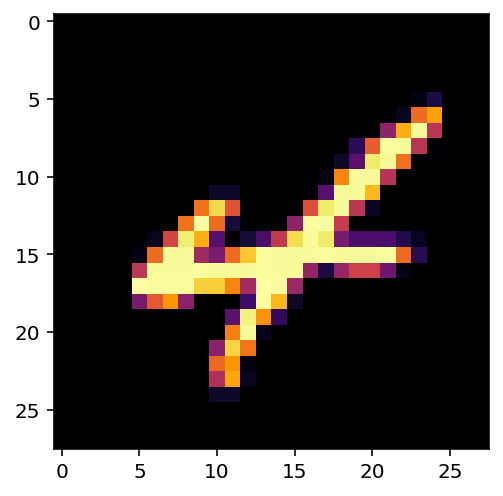

In [0]:
plt.imshow(images[42].numpy().squeeze(), cmap='inferno')

In [0]:
class Network(nn.Module):

    def __init__(self):
        super(Network, self).__init__()
        self.fc1 = nn.Linear(784, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 10)
        self.dropout = nn.Dropout(p=0.5)

    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.dropout(F.relu(self.fc2(x)))
        x = self.dropout(F.relu(self.fc3(x)))
        x = self.fc4(x)
        return x

In [0]:
model = Network()
model.to(device)

Network(
  (fc1): Linear(in_features=784, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=64, bias=True)
  (fc4): Linear(in_features=64, out_features=10, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)

In [0]:
optimizer = optim.SGD(model.parameters(), lr=0.003)
criterion = nn.CrossEntropyLoss()

In [0]:
epochs = 10

for epoch in range(epochs):

    training_loss = 0

    for idx, (images, labels) in enumerate(trainloader):
        
        images = images.to(device)
        labels = labels.to(device)

        # Training pass
        optimizer.zero_grad()

        output = model.forward(images)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()

        training_loss += loss.item()
        
    if(idx % 937 == 0):
        print("Training loss: {:.2f}".format(training_loss/len(trainloader)))

Training loss: 2.26
Training loss: 1.95
Training loss: 1.43
Training loss: 1.08
Training loss: 0.90
Training loss: 0.78
Training loss: 0.70
Training loss: 0.64
Training loss: 0.60
Training loss: 0.56


In [0]:
img = images[2].view(1, 784)
print(img.shape)

# Since we want to use the already pretrained weights to make some prediction
# we are turning off the gradients
with torch.no_grad():
    logits = model.forward(img)
    
print(logits)

torch.Size([1, 784])
tensor([[-4.6696, 10.3094,  2.0199,  1.4405, -3.4329, -2.9802, -4.5332,  1.4503,
          2.7366, -0.3229]], device='cuda:0')


[3.1204746e-07 9.9892551e-01 2.5088471e-04 1.4054592e-04 1.0747814e-06
 1.6902220e-06 3.5768471e-07 1.4192706e-04 5.1370304e-04 2.4097460e-05]


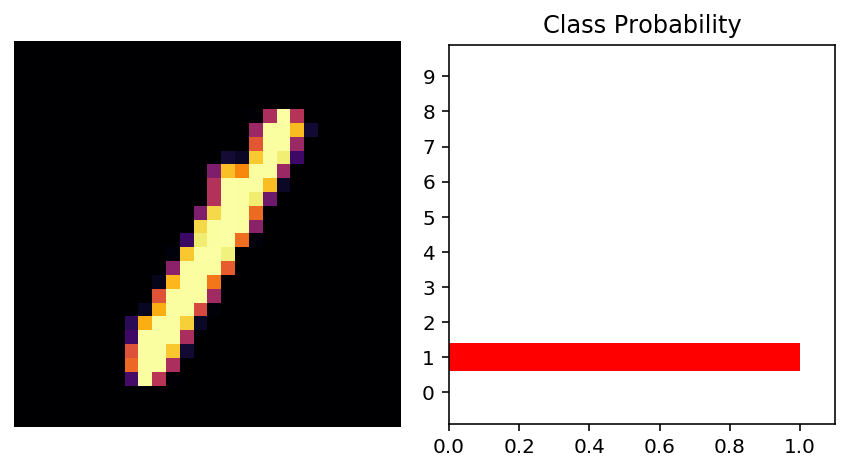

In [0]:
# We take the softmax for probabilites since our outputs are logits
probabilities = F.softmax(logits, dim=1).detach().cpu().numpy().squeeze()

print(probabilities)

fig, (ax1, ax2) = plt.subplots(figsize=(6,8), ncols=2)
ax1.imshow(img.view(1, 28, 28).detach().cpu().numpy().squeeze(), cmap='inferno')
ax1.axis('off')
ax2.barh(np.arange(10), probabilities, color='r' )
ax2.set_aspect(0.1)
ax2.set_yticks(np.arange(10))
ax2.set_yticklabels(np.arange(10))
ax2.set_title('Class Probability')
ax2.set_xlim(0, 1.1)

plt.tight_layout()